# Autores
- Jhon Alejandro Jaramillo Echeverri
- Juan Sebastián Salazar Luna

# Máquinas de Vectores de Soporte (SVM)

**Las máquinas de vectores de soporte (SVM)** son una categoría muy utilizada y poderosa de algoritmos de aprendizaje automático. Hay muchas variaciones en la idea básica de un SVM. Un SVM intenta **separar al máximo** las clases al encontrar el **vector de soporte** con la tasa de error más baja o la separación máxima. Los SVM pueden usar muchos tipos de **funciones del núcleo**. Las funciones del núcleo más comunes son **lineal** y la **función de base radial** o **RBF**. La función de base lineal intenta separar las clases al encontrar hiperplanos en el espacio de características que separan las clases al máximo. El RBF utiliza un conjunto de núcleos locales en forma de Gauss para encontrar una separación no lineal de las clases.

Consiste en seleccionar como clasificador óptimo al que se conoce como maximal margin hyperplane o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento.
Para obtenerlo, se tiene que calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina como de alejado está el hiperplano de las observaciones de entrenamiento.

*https://rpubs.com/Joaquin_AR/267926

## 1. Librerias y configuraciones previas

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn import svm


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 2. Funciones

In [ ]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [ ]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./Data/clas_Vertimiento_Prep.csv')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8684 entries, 0 to 8683
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   codigo_embalse       8684 non-null   object 
 1   region               8684 non-null   object 
 2   volumen_util         8684 non-null   int64  
 3   capacidad_util       8684 non-null   int64  
 4   volumen_total        8684 non-null   int64  
 5   VertimientosEnergia  8684 non-null   float64
 6   fecha                8684 non-null   object 
 7   vertimientos         8684 non-null   float64
 8   duracion             8546 non-null   object 
 9   etiqueta             8684 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 678.6+ KB


## 4. Visualización de datos

### Variables de entrada

In [ ]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,codigo_embalse,region,fecha,duracion
0,GUAVIO,Oriente,2014-05-12,P1D
1,SANLOREN,Antioquia,2022-08-02,P1D


In [ ]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,vertimientos,etiqueta
0,578235700,2095258858,628685700,0.000000e+00,0.00,0
1,441580700,424496733,485893800,1.134042e+07,11340415.15,1


In [ ]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('etiqueta')

### Variable de salida

In [ ]:
# Distriución de la variable de salida

d.groupby('etiqueta').etiqueta.count().sort_values(ascending=False)

etiqueta
0    4342
1    4342
Name: etiqueta, dtype: int64

## 5. Transformación de datos

### Creación de variables Dummies

In [ ]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8684 entries, 0 to 8683
Columns: 3639 entries, volumen_util to fecha_2025-03-31
dtypes: bool(3633), float64(2), int64(4)
memory usage: 30.5 MB


## 6. Creación del modelo

### Dividir el conjunto de datos

In [ ]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('etiqueta')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='etiqueta')
y = d['etiqueta']

In [ ]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [ ]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['volumen_util', 'capacidad_util', 'volumen_total', 'VertimientosEnergia', 'vertimientos']


In [ ]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,vertimientos
7941,0.0623,0.0565,0.0682,0.0073,0.0073
655,0.0274,0.0571,0.0371,0.0000,0.0000


### Creación del modelo

#### 6.1. Lineal y método de retención (*holdout method*)

##### Creación y entrenamiento del modelo

In [ ]:
#Creación del modelo

modelSVC = svm.SVC(kernel='linear')

#Entrenamiento del modelo con 80% de training
modelSVC.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = modelSVC.predict(X_test)

### Evaluación del modelo

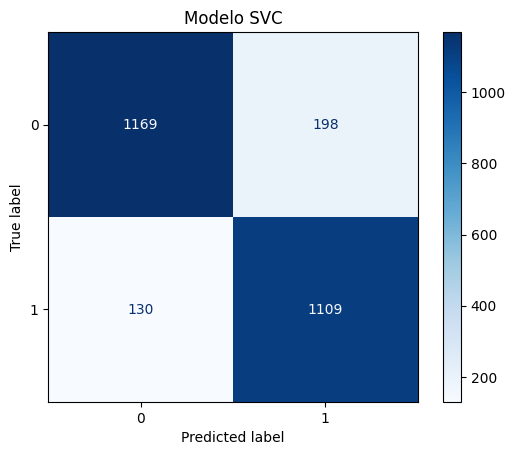

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1367
           1       0.85      0.90      0.87      1239

    accuracy                           0.87      2606
   macro avg       0.87      0.88      0.87      2606
weighted avg       0.88      0.87      0.87      2606



In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

# Mostrar la visualización
disp.plot(cmap='Blues')

# Configurar el título
plt.title('Modelo SVC')

# Mostrar la figura
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_test, y_pred))

In [ ]:
#f1-Score
print("f1-score:",metrics.f1_score(y_test, y_pred))

f1-score: 0.8711704634721131


In [ ]:
# Crear un dataframe para guardar los resultados
dfResults = pd.DataFrame(columns=['Tipo', 'f1-score'])

# Crear un nuevo DataFrame con los resultados
new_row = pd.DataFrame([{'Tipo': 'Lineal y método de retención', 'f1-score': metrics.f1_score(y_test, y_pred)}])

# Concatenar el nuevo DataFrame con el existente
dfResults = pd.concat([dfResults, new_row], ignore_index=True)

# Mostrar el DataFrame actualizado
print(dfResults)

                           Tipo  f1-score
0  Lineal y método de retención    0.8712


#### 6.2. Lineal y validación cruzada (*Cross validation*)

In [ ]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns ='etiqueta')
y = d['etiqueta']

# la validación cruzada se realiza sobre todo el dataset
X_Completo = X
y_Completo = y

In [ ]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head()

,volumen_util,capacidad_util,volumen_total,VertimientosEnergia,vertimientos
0,0.0380,0.1132,0.0367,0.0000,0.0000
1,0.0290,0.0215,0.0283,0.0756,0.0756
2,0.0031,0.0013,0.0024,0.0000,0.0000
3,0.0059,0.0048,0.0093,0.0000,0.0000
4,0.0035,0.0281,0.0138,0.0000,0.0000


In [ ]:
# Guardar el scaler
joblib.dump(scaler, './Data/scaler/minmaxFull_Vertimientos.pkl')

['./Data/scaler/minmaxFull_Vertimientos.pkl']

Evaluación del modelo

In [ ]:
CV = 10  # Número de pliegues
scoring = 'f1'

# Paralelizar el cálculo de cross_val_score usando todos los núcleos disponibles
accuracies = cross_val_score(
    modelSVC, X_Completo, y_Completo, cv=CV, scoring=scoring, n_jobs=-1)

# Crear un DataFrame con los resultados
entries = [(fold_idx, accuracy) for fold_idx, accuracy in enumerate(accuracies)]
cv_df = pd.DataFrame(entries, columns=['fold_idx', 'f1-Score'])

# Mostrar los resultados
print(cv_df)
print('f1-score promedio:', cv_df['f1-Score'].mean())

   fold_idx  f1-Score
0         0    0.8987
1         1    0.8874
2         2    0.8879
3         3    0.9041
4         4    0.9060
5         5    0.9005
6         6    0.8774
7         7    0.9044
8         8    0.8874
9         9    0.9138
f1-score promedio: 0.8967610842193448


#### Evaluación del modelo

### 7. Afinando el modelo (tuning)

#### 7.1. Lineal e hiperparámetro *C*  (con validación cruzada - *Cross validation*)

##### Identificacion del mejor hiperparametro *C*

In [ ]:
#Definicion del modelo
from sklearn.model_selection import RandomizedSearchCV


modelsvmL = svm.SVC(kernel='linear', probability = True, random_state = 0)

# Establecemos un grid con los valores de coste que queremos evaluar
grid_hiperparametros = {'C': [0.01, 0.1, 1, 10]}

# definicion de la variable con el número de pliegues
CV = 3

X_sample = X_Completo.sample(frac=0.5, random_state=42)  # Usa el 50% de los datos
y_sample = y_Completo.loc[X_sample.index]

# las metricas sobre las se evaluará el modelo
scoring = 'f1'

# Definimos la busqueda mediante 10-fold CV
grid_svmL = GridSearchCV(
    estimator=modelsvmL,
    param_grid=grid_hiperparametros,
    cv=CV,
    scoring=scoring,
    return_train_score=True,
    verbose=4,
    n_jobs=-1  # Usa todos los núcleos disponibles
)



# Aplicamos la busqueda
grid_svmL.fit(X_Completo, y_Completo)

#gridsvmL.cv_results_.keys()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 2/3] END ..........C=10;, score=(train=0.986, test=0.895) total time=12.3min
[CV 3/3] END ..........C=10;, score=(train=0.986, test=0.902) total time=12.3min
[CV 1/3] END ..........C=10;, score=(train=0.987, test=0.890) total time=15.0min
[CV 3/3] END ...........C=1;, score=(train=0.966, test=0.897) total time=17.0min
[CV 2/3] END ...........C=1;, score=(train=0.968, test=0.892) total time=18.3min
[CV 1/3] END ...........C=1;, score=(train=0.973, test=0.886) total time=19.1min
[CV 3/3] END .........C=0.1;, score=(train=0.813, test=0.801) total time=19.9min
[CV 1/3] END .........C=0.1;, score=(train=0.822, test=0.818) total time=20.4min
[CV 2/3] END .........C=0.1;, score=(train=0.816, test=0.818) total time=22.7min
[CV 1/3] END ........C=0.01;, score=(train=0.788, test=0.774) total time=23.7min
[CV 2/3] END ........C=0.01;, score=(train=0.768, test=0.773) total time=23.8min
[CV 3/3] END ........C=0.01;, score=(train=0.794,

GridSearchCV(cv=3,
             estimator=SVC(kernel='linear', probability=True, random_state=0),
             n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='f1', verbose=4)

In [ ]:
# Resultados
resultados = pd.DataFrame(grid_svmL.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
3,10.0000,0.8958,0.0052,0.9864,0.0004
2,1.0000,0.8915,0.0044,0.9692,0.0028
1,0.1000,0.8123,0.0082,0.8171,0.0038
0,0.0100,0.7783,0.0066,0.7832,0.0113


In [ ]:
# Obtener los resultados del grid search
results_grid_svmL = pd.DataFrame(grid_svmL.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_svmL = ['param_C']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_svmL_filtered = results_grid_svmL[columns_grid_svmL]

# Crear la columna scoreWithStd: f1 / std
results_grid_svmL_filtered['scoreWithStd'] = results_grid_svmL_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_svmL_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
print(results_grid_svmL_filtered[['param_C', 'mean_test_score', 'std_test_score', 'scoreWithStd']])

   param_C  mean_test_score  std_test_score  scoreWithStd
0   0.0100           0.7783          0.0066      118.1442
1   0.1000           0.8123          0.0082       98.6109
2   1.0000           0.8915          0.0044      203.8219
3  10.0000           0.8958          0.0052      171.1791


In [ ]:
# Top 3 de los mejores scores
results_grid_svmL_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_C',  'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_C,mean_test_score,std_test_score,scoreWithStd
2,1.0000,0.8915,0.0044,203.8219
3,10.0000,0.8958,0.0052,171.1791
0,0.0100,0.7783,0.0066,118.1442


#### Evaluación del modelo

In [ ]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_svmL_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_C               1.0000
mean_test_score       0.8915
std_test_score        0.0044
split0_test_score     0.8860
split1_test_score     0.8919
split2_test_score     0.8966
scoreWithStd        203.8219
Name: 2, dtype: float64

In [ ]:
# Crear un nuevo DataFrame con los resultados
new_row = pd.DataFrame([{
    'Tipo': 'Lineal e hiperparámetro C con validación cruzada',
    'f1-score': results_grid_svmL_filtered.loc[indice_max_scoreWithStd]['mean_test_score']
}])

# Concatenar el nuevo DataFrame con el existente
dfResults = pd.concat([dfResults, new_row], ignore_index=True)

# Mostrar el DataFrame actualizado
dfResults

,Tipo,f1-score
0,Lineal y método de retención,0.8712
1,Lineal e hiperparámetro C con validación cruzada,0.8915


#### Creación del modelo final

In [ ]:
# Reducir el tamaño del conjunto de datos al 50%
X_sample = X_Completo.sample(frac=0.5, random_state=42)
y_sample = y_Completo.loc[X_sample.index]

# Usar los mejores parámetros para crear el modelo
modelsvmL.set_params(kernel='linear',
                     C=results_grid_svmL_filtered.loc[indice_max_scoreWithStd]['param_C'])

# Entrenar el modelo con la muestra
modelsvmL.fit(X_sample, y_sample)

SVC(C=np.float64(1.0), kernel='linear', probability=True, random_state=0)

7.2. Polinómico e hiperparámetros: C y degree (con validación cruzada - Cross validation)

Identificación del mejor hiperparametro C y degree

In [ ]:
# Definición del modelo
modelsvmP = svm.SVC(kernel='poly', probability=True, random_state=0)

# Reducir el rango de valores de C y degree
grid_hiperparametros = {'C': [0.01, 0.1, 1, 10],  # Reducir el rango de C
                        'degree': [2]}  # Evaluar solo un grado

# Reducir el tamaño de la muestra
X_sample = X_Completo.sample(frac=0.3, random_state=42)  # Usa el 30% de los datos
y_sample = y_Completo.loc[X_sample.index]

# Usar RandomizedSearchCV con menos iteraciones
grid_svmP = RandomizedSearchCV(
    estimator=modelsvmP,
    param_distributions=grid_hiperparametros,
    n_iter=5,  # Probar solo 5 combinaciones
    cv=3,  # Reducir a 3 pliegues
    scoring='f1',
    random_state=42,
    verbose=4,
    n_jobs=-1  # Paralelizar
)

# Aplicar la búsqueda
grid_svmP.fit(X_sample, y_sample)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 2/3] END ...................C=0.1, degree=2;, score=0.740 total time= 3.0min
[CV 3/3] END ..................C=0.01, degree=2;, score=0.426 total time= 3.1min
[CV 3/3] END ...................C=0.1, degree=2;, score=0.740 total time= 3.1min
[CV 1/3] END ...................C=0.1, degree=2;, score=0.756 total time= 3.1min
[CV 2/3] END ....................C=10, degree=2;, score=0.832 total time= 3.1min
[CV 3/3] END .....................C=1, degree=2;, score=0.774 total time= 3.1min
[CV 3/3] END ....................C=10, degree=2;, score=0.843 total time= 3.2min
[CV 1/3] END ....................C=10, degree=2;, score=0.853 total time= 3.2min
[CV 1/3] END .....................C=1, degree=2;, score=0.792 total time= 3.2min
[CV 1/3] END ..................C=0.01, degree=2;, score=0.429 total time= 3.4min
[CV 2/3] END ..................C=0.01, degree=2;, score=0.439 total time= 3.4min
[CV 2/3] END .....................C=1, degree=2;,

RandomizedSearchCV(cv=3,
                   estimator=SVC(kernel='poly', probability=True,
                                 random_state=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10], 'degree': [2]},
                   random_state=42, scoring='f1', verbose=4)

In [ ]:
# Resultados
resultados = pd.DataFrame(grid_svmP.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_degree,param_C,mean_test_score,std_test_score
3,2,10.0000,0.8425,0.0086
2,2,1.0000,0.7843,0.0075
1,2,0.1000,0.7452,0.0075
0,2,0.0100,0.4312,0.0054


In [ ]:
# Obtener los resultados del grid search
results_grid_svmP = pd.DataFrame(grid_svmP.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_svmP = ['param_C']  + \
                    ['param_degree']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_svmP_filtered = results_grid_svmP[columns_grid_svmP]

# Crear la columna scoreWithStd: f1 / std
results_grid_svmP_filtered['scoreWithStd'] = results_grid_svmP_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_svmP_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
print(results_grid_svmP_filtered[['param_C', 'param_degree', 'mean_test_score', 'std_test_score', 'scoreWithStd']])

   param_C  param_degree  mean_test_score  std_test_score  scoreWithStd
0   0.0100             2           0.4312          0.0054       79.7292
1   0.1000             2           0.7452          0.0075       99.9808
2   1.0000             2           0.7843          0.0075      105.0286
3  10.0000             2           0.8425          0.0086       97.4736


In [ ]:
# Top 3 de los mejores scores
results_grid_svmP_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_C', 'param_degree', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_C,param_degree,mean_test_score,std_test_score,scoreWithStd
2,1.0000,2,0.7843,0.0075,105.0286
1,0.1000,2,0.7452,0.0075,99.9808
3,10.0000,2,0.8425,0.0086,97.4736


#### Evaluación del modelo

In [ ]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_svmP_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_C               1.0000
param_degree          2.0000
mean_test_score       0.7843
std_test_score        0.0075
split0_test_score     0.7922
split1_test_score     0.7863
split2_test_score     0.7743
scoreWithStd        105.0286
Name: 2, dtype: float64

In [ ]:
# Crear un nuevo DataFrame con los resultados
new_row = pd.DataFrame([{
    'Tipo': 'Polinómico e hiperparámetros: C y degree con validación cruzada',
    'f1-score': results_grid_svmP_filtered.loc[indice_max_scoreWithStd]['mean_test_score']
}])

# Concatenar el nuevo DataFrame con el existente
dfResults = pd.concat([dfResults, new_row], ignore_index=True)

# Mostrar el DataFrame actualizado
dfResults

,Tipo,f1-score
0,Lineal y método de retención,0.8712
1,Lineal e hiperparámetro C con validación cruzada,0.8915
2,Polinómico e hiperparámetros: C y degree con v...,0.7843


#### Creación del modelo final

In [ ]:
# Usar los mejores parámetros para crear el modelo
modelsvmP.set_params(
    kernel='poly',
    C=results_grid_svmP_filtered.loc[indice_max_scoreWithStd]['param_C'],
    degree=int(results_grid_svmP_filtered.loc[indice_max_scoreWithStd]['param_degree'])  # Convertir a int
)

# Entrenar el modelo
modelsvmP.fit(X_Completo, y_Completo)

SVC(C=np.float64(1.0), degree=2, kernel='poly', probability=True,
    random_state=0)

#### 7.3. Radial e hiperparámetros: *C* y *gamma*  (con validación cruzada  - *Cross validation*)

##### Identificación del mejor hiperparametro *C* y *gamma*

In [ ]:
# Definición del modelo
modelsvmR = svm.SVC(kernel='rbf', probability=True, random_state=0)

# Reducir el rango de valores de C y gamma
grid_hiperparametros = {'C': [0.01, 0.1, 1, 10],  # Reducir el rango de C
                        'gamma': ['scale']}  # Evaluar solo un valor de gamma

# Reducir el tamaño de la muestra
X_sample = X_Completo.sample(frac=0.3, random_state=42)  # Usa el 30% de los datos
y_sample = y_Completo.loc[X_sample.index]

# Usar RandomizedSearchCV con menos iteraciones
grid_svmR = RandomizedSearchCV(
    estimator=modelsvmR,
    param_distributions=grid_hiperparametros,
    n_iter=5,  # Probar solo 5 combinaciones
    cv=3,  # Reducir a 3 pliegues
    scoring='f1',
    random_state=42,
    verbose=4,
    n_jobs=-1  # Paralelizar
)

# Aplicar la búsqueda
grid_svmR.fit(X_sample, y_sample)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[CV 1/3] END ..................C=1, gamma=scale;, score=0.802 total time= 3.0min
[CV 1/3] END ................C=0.1, gamma=scale;, score=0.730 total time= 3.2min
[CV 3/3] END .................C=10, gamma=scale;, score=0.863 total time= 3.2min
[CV 2/3] END ..................C=1, gamma=scale;, score=0.800 total time= 3.3min
[CV 3/3] END ................C=0.1, gamma=scale;, score=0.727 total time= 3.4min
[CV 1/3] END .................C=10, gamma=scale;, score=0.864 total time= 3.4min
[CV 1/3] END ...............C=0.01, gamma=scale;, score=0.429 total time= 3.4min
[CV 2/3] END ...............C=0.01, gamma=scale;, score=0.436 total time= 3.4min
[CV 2/3] END ................C=0.1, gamma=scale;, score=0.715 total time= 3.4min
[CV 3/3] END ..................C=1, gamma=scale;, score=0.787 total time= 3.5min
[CV 3/3] END ...............C=0.01, gamma=scale;, score=0.426 total time= 3.6min
[CV 2/3] END .................C=10, gamma=scale;, score=0.860 total time= 3.6min


RandomizedSearchCV(cv=3, estimator=SVC(probability=True, random_state=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'gamma': ['scale']},
                   random_state=42, scoring='f1', verbose=4)

In [ ]:
# Resultados
resultados = pd.DataFrame(grid_svmR.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_gamma,param_C,mean_test_score,std_test_score
3,scale,10.0000,0.8625,0.0017
2,scale,1.0000,0.7967,0.0068
1,scale,0.1000,0.7240,0.0067
0,scale,0.0100,0.4303,0.0042


In [ ]:
# Obtener los resultados del grid search
results_grid_svmR = pd.DataFrame(grid_svmR.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_svmR = ['param_C']  + \
                    ['param_gamma']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_svmR_filtered = results_grid_svmR[columns_grid_svmR]

# Crear la columna scoreWithStd: f1 / std
results_grid_svmR_filtered['scoreWithStd'] = results_grid_svmR_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_svmR_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
print(results_grid_svmR_filtered[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'scoreWithStd']])

   param_C param_gamma  mean_test_score  std_test_score  scoreWithStd
0   0.0100       scale           0.4303          0.0042      103.0007
1   0.1000       scale           0.7240          0.0067      107.8059
2   1.0000       scale           0.7967          0.0068      117.9166
3  10.0000       scale           0.8625          0.0017      500.5581


In [ ]:
#Top 3 de los mejores scores
results_grid_svmR_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_C,param_gamma,mean_test_score,std_test_score,scoreWithStd
3,10.0000,scale,0.8625,0.0017,500.5581
2,1.0000,scale,0.7967,0.0068,117.9166
1,0.1000,scale,0.7240,0.0067,107.8059


Evaluación del modelo

In [ ]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_svmR_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_C              10.0000
param_gamma            scale
mean_test_score       0.8625
std_test_score        0.0017
split0_test_score     0.8643
split1_test_score     0.8602
split2_test_score     0.8630
scoreWithStd        500.5581
Name: 3, dtype: object

In [ ]:
# Crear un nuevo DataFrame con los resultados
new_row = pd.DataFrame([{
    'Tipo': 'Radial e hiperparámetros: C y gamma con validación cruzada',
    'f1-score': results_grid_svmR_filtered.loc[indice_max_scoreWithStd]['mean_test_score']
}])

# Concatenar el nuevo DataFrame con el existente
dfResults = pd.concat([dfResults, new_row], ignore_index=True)

# Mostrar el DataFrame actualizado
dfResults

,Tipo,f1-score
0,Lineal y método de retención,0.8712
1,Lineal e hiperparámetro C con validación cruzada,0.8915
2,Polinómico e hiperparámetros: C y degree con v...,0.7843
3,Radial e hiperparámetros: C y gamma con valida...,0.8625


#### Creación del modelo final

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

# Definición del modelo
modelsvmR = svm.SVC(kernel='rbf', probability=True, random_state=0)

# Reducir el rango de valores de C y gamma
grid_hiperparametros = {
    'C': [0.1, 1, 10],  # Reducir el rango de C
    'gamma': ['scale']  # Evaluar solo un valor de gamma
}

# Reducir el tamaño de la muestra
X_sample = X_Completo.sample(frac=0.3, random_state=42)  # Usa el 30% de los datos
y_sample = y_Completo.loc[X_sample.index]

# Usar RandomizedSearchCV con menos iteraciones
grid_svmR = RandomizedSearchCV(
    estimator=modelsvmR,
    param_distributions=grid_hiperparametros,
    n_iter=5,  # Probar solo 5 combinaciones
    cv=3,  # Reducir a 3 pliegues
    scoring='f1',
    random_state=42,
    verbose=4,
    n_jobs=-1  # Paralelizar
)

# Aplicar la búsqueda
grid_svmR.fit(X_sample, y_sample)

# Usar los mejores parámetros para crear el modelo final
modelsvmR.set_params(
    kernel='rbf',
    C=grid_svmR.best_params_['C'],
    gamma=grid_svmR.best_params_['gamma']
)

# Entrenar el modelo con el conjunto completo
modelsvmR.fit(X_Completo, y_Completo)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 2/3] END ..................C=1, gamma=scale;, score=0.800 total time= 2.5min
[CV 1/3] END ..................C=1, gamma=scale;, score=0.802 total time= 2.6min
[CV 1/3] END ................C=0.1, gamma=scale;, score=0.730 total time= 2.6min
[CV 3/3] END ..................C=1, gamma=scale;, score=0.787 total time= 2.6min
[CV 2/3] END ................C=0.1, gamma=scale;, score=0.715 total time= 2.6min
[CV 3/3] END .................C=10, gamma=scale;, score=0.863 total time= 2.6min
[CV 2/3] END .................C=10, gamma=scale;, score=0.860 total time= 2.6min
[CV 1/3] END .................C=10, gamma=scale;, score=0.864 total time= 2.6min
[CV 3/3] END ................C=0.1, gamma=scale;, score=0.727 total time= 2.6min


SVC(C=10, probability=True, random_state=0)

### 8. Eligiendo el modelo

In [ ]:
dfResults

,Tipo,f1-score
0,Lineal y método de retención,0.8712
1,Lineal e hiperparámetro C con validación cruzada,0.8915
2,Polinómico e hiperparámetros: C y degree con v...,0.7843
3,Radial e hiperparámetros: C y gamma con valida...,0.8625


### Guardar modelo

In [ ]:
#Se guardan los modelos de SVC

joblib.dump(modelsvmL, './Data/clasificacion/SVC_CV_lineal.pkl')

joblib.dump(modelsvmP, './Data/clasificacion/SVC_CV_poly.pkl')

joblib.dump(modelsvmR, './Data/clasificacion/SVC_CV_rbf.pkl')


['./Data/clasificacion/SVC_CV_rbf.pkl']

#### Referencias


- Maquinas de vectores de soporte

    - https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
    
    
- Tuning parametros SVM
    - https://github.com/CristinaGil/Ciencia-de-Datos-Python/blob/master/maquinas_vector_soporte.ipynb
    

- Hiperparametros y Kernels

    - https://ichi.pro/es/hiperparametros-de-svm-explicados-con-visualizaciones-22257741819931

    - https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180


- *Multicolinealidad:*
    - https://www.analyticslane.com/2020/04/22/solucionar-la-multicolinealidad-con-vif/


- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html